In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
dataset = MNIST(root='data/', train=True, transform = transforms.ToTensor(), download=True)
test_data = MNIST(root='data/' , train=False , transform= transforms.ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
print(len(dataset))
print(len(test_data))

60000
10000


In [14]:
dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [0]:
validation_split = 0.1
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size 

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [0]:
batchSize = 32
train_loader = DataLoader(train_ds,batch_size=batchSize,shuffle= True)
val_loader = DataLoader(val_ds , batch_size= batchSize,pin_memory=True)
test_loader = DataLoader(test_data , batch_size= batchSize,pin_memory=True)

images.shape: torch.Size([32, 1, 28, 28])


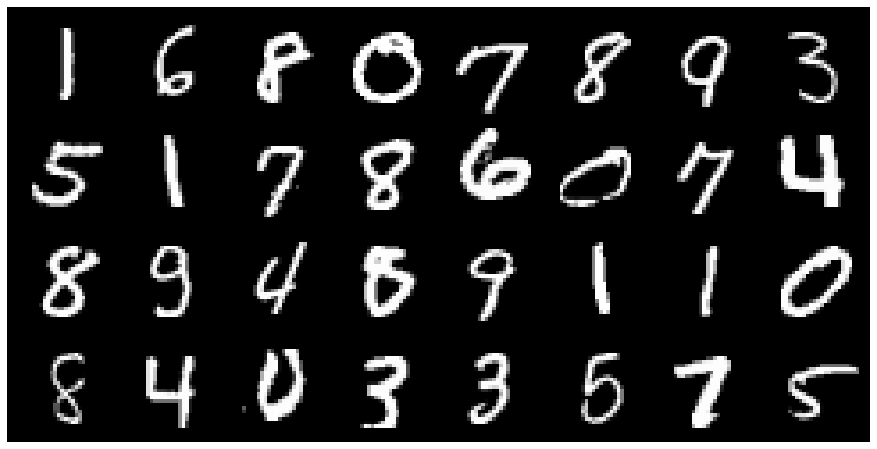

In [41]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [0]:
input_shape = 28*28
num_classes = 10

In [0]:
class MNIST_Model(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_shape, 32)
    self.linear2 = nn.Linear(32,num_classes)

  
  def forward(self,xb):
    xb = xb.reshape(-1,784)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self,batch):
    images,label = batch
    out = self(images)
    loss = F.cross_entropy(out,label)
    return loss


  def validation_step(self,batch):
    images,label = batch
    out = self(images)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss' : loss.detach() , 'val_acc': acc.detach()}

  def validation_epoch_end(self,outputs):
    batch_losses =  [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accuracy = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accuracy).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [0]:
model = MNIST_Model()

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [44]:
device = get_default_device()
device

device(type='cuda')

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [46]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([32, 1, 28, 28])
cuda:0


In [0]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [51]:
to_device(model, device)

MNIST_Model(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [52]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9426, val_acc: 0.5971
Epoch [1], val_loss: 1.4477, val_acc: 0.6922
Epoch [2], val_loss: 1.0675, val_acc: 0.7671
Epoch [3], val_loss: 0.8362, val_acc: 0.8133
Epoch [4], val_loss: 0.6982, val_acc: 0.8351
Epoch [5], val_loss: 0.6098, val_acc: 0.8544
Epoch [6], val_loss: 0.5509, val_acc: 0.8662
Epoch [7], val_loss: 0.5090, val_acc: 0.8702
Epoch [8], val_loss: 0.4769, val_acc: 0.8773
Epoch [9], val_loss: 0.4524, val_acc: 0.8815


In [54]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4336, val_acc: 0.8860
Epoch [1], val_loss: 0.4179, val_acc: 0.8891
Epoch [2], val_loss: 0.4052, val_acc: 0.8916
Epoch [3], val_loss: 0.3945, val_acc: 0.8926
Epoch [4], val_loss: 0.3850, val_acc: 0.8953
Epoch [5], val_loss: 0.3771, val_acc: 0.8958
Epoch [6], val_loss: 0.3699, val_acc: 0.8978
Epoch [7], val_loss: 0.3638, val_acc: 0.8993
Epoch [8], val_loss: 0.3584, val_acc: 0.8994
Epoch [9], val_loss: 0.3538, val_acc: 0.9018


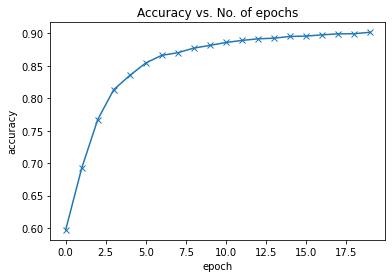

In [55]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [59]:
evaluate(model,test_loader)

{'val_acc': 0.9017619490623474, 'val_loss': 0.35378557443618774}